# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

import torch
import torch.nn.functional as F
import botorch
import gpytorch

from src.encoder import SelfiesEncoder
from src.vae import MolecularVAE
from src.loss import VAELoss, SigmoidScheduler, CyclicScheduler, ConstantScheduler
from src.train import VAELoss, train_vae
from src.transforms import StandardScaler, UnitCubeScaler
from src.molecules import penalized_logp

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

Download raw dataset:

In [7]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join("data", "qm9.csv"), index=False)

Add selfies encoding to raw data:

In [16]:
df = pd.read_csv(os.path.join("data", "qm9.csv"))

df["selfies"] = [sf.encoder(x, strict=False) for x in df.smiles]
df["penalized_logp"] = [penalized_logp(Chem.MolFromSmiles(s)) for s in df.smiles]
df = df[["mol_id", "smiles", "selfies", "penalized_logp"]]

df.to_csv(os.path.join("data", "qm9_processed.csv"), index=False)

Generate one-hot enocding for selfies strings:

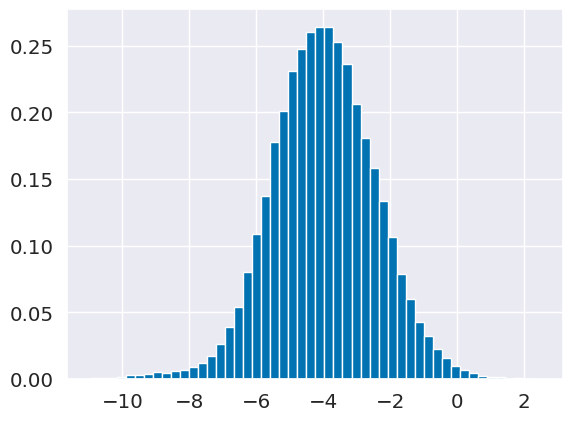

In [19]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))
df.penalized_logp.hist(bins=50, density=True)
plt.show()

Encode the inputs and extract the targets:

In [20]:
selfies = df.selfies
selfies_encoder = SelfiesEncoder.build(selfies)

In [22]:
inputs = []
for s in tqdm(selfies):
    inputs.append(selfies_encoder.encode_one_hot(s))
inputs = torch.tensor(inputs)

targets = torch.tensor(df.penalized_logp)
targets = targets.view(-1, 1)

inputs.shape, targets.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:03<00:00, 37847.85it/s]


(torch.Size([133885, 21, 29]), torch.Size([133885, 1]))

Split the data and save:

In [23]:
torch.manual_seed(42)

n = len(inputs)
test_frac = 0.25
test_size = int(test_frac * n)
train_size = n - test_size

indices = torch.randperm(n)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

inputs_train = inputs[train_indices]
inputs_test = inputs[test_indices]

targets_train = targets[train_indices]
targets_test = targets[test_indices]

torch.save(inputs_train, os.path.join("data", "qm9_inputs_train.pt"))
torch.save(inputs_test, os.path.join("data", "qm9_inputs_test.pt"))

torch.save(targets_train, os.path.join("data", "qm9_targets_train.pt"))
torch.save(targets_test, os.path.join("data", "qm9_targets_test.pt"))

# VAE

## Training

In [23]:
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train = torch.load(os.path.join("data", "qm9_inputs_train.pt"))
x_test = torch.load(os.path.join("data", "qm9_inputs_test.pt"))

y_train = torch.load(os.path.join("data", "qm9_targets_train.pt"))
y_test = torch.load(os.path.join("data", "qm9_targets_test.pt"))

x_train = x_train.to(device).float()
x_test = x_test.to(device).float()
y_train = y_train.to(device).float()
y_test = y_test.to(device).float()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [24]:
batch_size = 250

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [25]:
latent_size = 100
model = MolecularVAE(latent_size=latent_size)
model.to(device)

print(f"# Parameters = {model.n_parameters()}")
model

# Parameters = 4171136


MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(9, 10, kernel_size=(10,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=80, out_features=400, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=400, out_features=100, bias=True)
  (encoder_logvar): Linear(in_features=400, out_features=100, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(100, 500, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=500, out_features=29, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(i

In [26]:
kl_scheduler = ConstantScheduler(beta=1e-3)
criterion = VAELoss(kl_scheduler = kl_scheduler)

learning_rate = 2e-3
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-5 ,
)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[15, 30, 50, 70, 90], 
    gamma=0.5
)

In [27]:
n_epochs = 120
tracker = train_vae(
    model,
    criterion,
    optimizer,
    
    lr_scheduler,
    train_loader,                                                                                                                                                                                                                  
    test_loader,
    n_epochs=n_epochs,
    print_every=1
)

0 | train_elbo = 26.766 | test_elbo = 25.015 | train_mse = 2.161 | test_mse = 2.715 | train_accuracy = 0.000 | test_accuracy = 0.000
1 | train_elbo = 22.978 | test_elbo = 21.178 | train_mse = 0.640 | test_mse = 0.734 | train_accuracy = 0.000 | test_accuracy = 0.000
2 | train_elbo = 20.383 | test_elbo = 19.066 | train_mse = 0.503 | test_mse = 0.670 | train_accuracy = 0.000 | test_accuracy = 0.000
3 | train_elbo = 19.329 | test_elbo = 17.843 | train_mse = 0.538 | test_mse = 0.510 | train_accuracy = 0.000 | test_accuracy = 0.000
4 | train_elbo = 17.244 | test_elbo = 15.394 | train_mse = 0.538 | test_mse = 0.521 | train_accuracy = 0.000 | test_accuracy = 0.001
5 | train_elbo = 13.712 | test_elbo = 13.067 | train_mse = 0.531 | test_mse = 0.603 | train_accuracy = 0.002 | test_accuracy = 0.003
6 | train_elbo = 10.707 | test_elbo = 9.502 | train_mse = 0.499 | test_mse = 0.456 | train_accuracy = 0.010 | test_accuracy = 0.018
7 | train_elbo = 8.400 | test_elbo = 8.175 | train_mse = 0.447 | test_

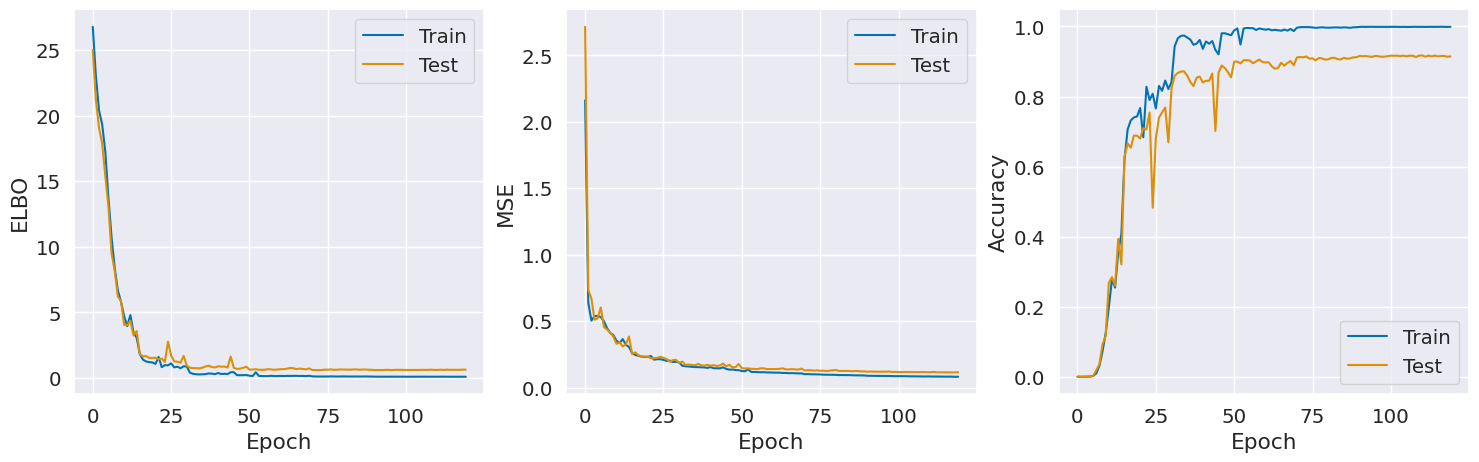

In [29]:
_, ax = plt.subplots(1, 3, figsize=(18, 5))

train_elbo = tracker.get("train_elbo")
test_elbo = tracker.get("test_elbo")

train_mse = tracker.get("train_mse")
test_mse = tracker.get("test_mse")

train_accuracy = tracker.get("train_accuracy")
test_accuracy = tracker.get("test_accuracy")

ax[0].plot(train_elbo[:,0], train_elbo[:,1], label='Train')
ax[0].plot(test_elbo[:,0], test_elbo[:,1], label='Test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('ELBO')
ax[0].legend()

ax[1].plot(train_mse[:,0], train_mse[:,1], label='Train')
ax[1].plot(test_mse[:,0], test_mse[:,1], label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].legend()

ax[2].plot(train_accuracy[:,0], train_accuracy[:,1], label='Train')
ax[2].plot(test_accuracy[:,0], test_accuracy[:,1], label='Test')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].legend()

# plt.savefig(os.path.join("images", f"vae_latent_{latent_size}_constant.png"))
plt.show()

In [30]:
# torch.save(model.state_dict(), os.path.join("models", f"vae_latent_{latent_size}_constant.pt"))

## Characterization

In [31]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

inputs_test = torch.load(os.path.join("data", "qm9_inputs_test.pt")).float()
targets_test = torch.load(os.path.join("data", "qm9_targets_test.pt"))

selfies = list(df.selfies)
selfies_encoder = SelfiesEncoder.build(selfies)

In [33]:
vae_tags = [(25, "constant"), (50, "constant"), (100, "constant")]

vaes = {}
for latent_size, beta in vae_tags:
    params = torch.load(os.path.join("models", f"vae_latent_{latent_size}_constant.pt"))
    vae = MolecularVAE(latent_size=latent_size)
    vae.load_state_dict(params)
    vae.eval()

    name = f"{latent_size}_{beta}"
    vaes[name] = vae   

### Latent Distribution

In [230]:
vae = vaes["50_constant"]

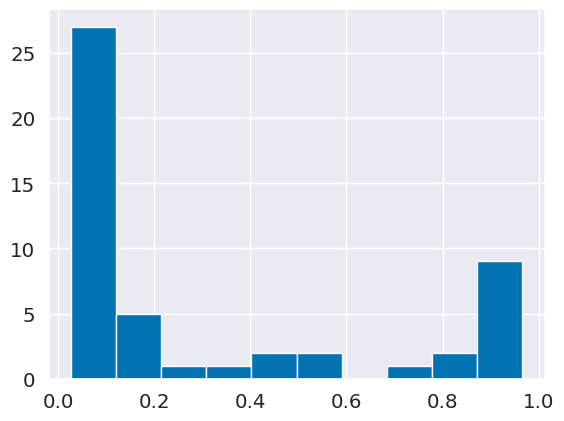

In [231]:
z_logvars = vae.encode(inputs_test)[1].detach().cpu()

z_stds = z_logvars.mean(dim=0).exp().sqrt()

plt.hist(z_stds, bins=10)
plt.show()

### Interpolation

In [232]:
start_selfie = sf.encoder("C")
end_selfie = sf.encoder("C(CC=O)C(CC=N)")

start_x = torch.tensor(selfies_encoder.encode_one_hot(start_selfie), dtype=torch.float32)
end_x = torch.tensor(selfies_encoder.encode_one_hot(end_selfie), dtype=torch.float32)

interp_x = vae.interpolate(start_x, end_x, 5)
interp_x = interp_x

interp_selfies = [selfies_encoder.decode_tensor(x) for x in interp_x]
interp_mols = [Chem.MolFromSmiles(sf.decoder(s)) for s in interp_selfies]

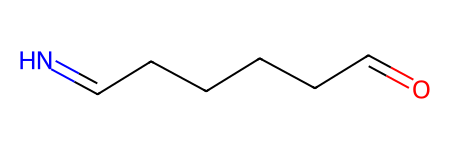

In [233]:
Chem.MolFromSmiles(sf.decoder(end_selfie))

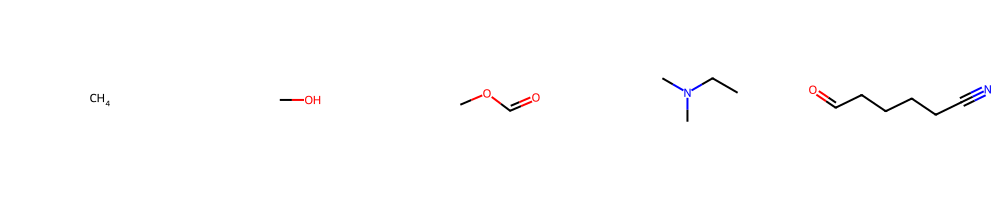

In [234]:
Chem.Draw.MolsToGridImage(interp_mols, molsPerRow=5)

### Regression

In [235]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

import umap

torch.manual_seed(145);

In [236]:
x_sample = torch.load(os.path.join("data", "qm9_inputs_test.pt"))
y_sample = torch.load(os.path.join("data", "qm9_targets_test.pt"))

sample_indices = torch.randperm(x_sample.shape[0])

x_sample = x_sample[sample_indices]
y_sample = y_sample[sample_indices]

x_sample = x_sample[::10].float()
y_sample = y_sample[::10].float()

x_sample.shape

torch.Size([3348, 21, 29])

In [237]:
selfies_sample = [selfies_encoder.decode_tensor(xi) for xi in x_sample]
mols_sample = [Chem.MolFromSmiles(sf.decoder(s)) for s in selfies_sample]

In [238]:
z = vae.encode(x_sample)[0].detach().double()

y = torch.tensor(y_sample).view(-1, 1).double()

/tmp/ipykernel_18792/1797932818.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y_sample).view(-1, 1).double()


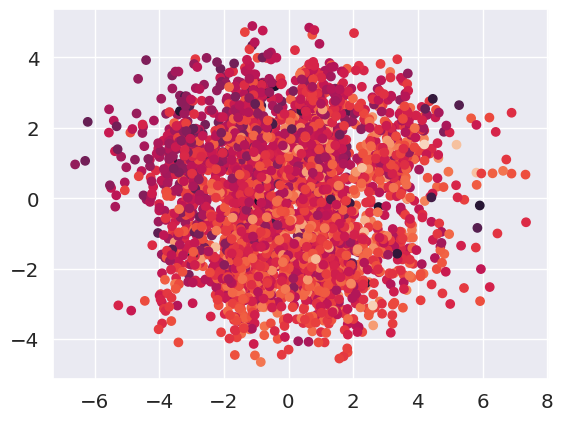

In [239]:
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=y)
plt.show()

In [240]:
indices = torch.randperm(z.shape[0])

n_train = 500

ind_train = indices[:n_train]
ind_test = indices[n_train:]

z_train = z[ind_train]
z_test = z[ind_test]

y_train = y[ind_train]
y_test = y[ind_test]

input_scaler = UnitCubeScaler.build(z_train)
z_train_scaled = input_scaler.transform(z_train)
z_test_scaled = input_scaler.transform(z_test)

output_scaler = StandardScaler.build(y_train)
y_train_scaled = output_scaler.transform(y_train)
y_test_scaled = output_scaler.transform(y_test)

In [241]:
gp = SingleTaskGP(z_train_scaled, y_train)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

mll = fit_gpytorch_mll(mll)

/home/sfriedowitz/miniconda3/envs/ssl/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-3.9199], dtype=torch.float64), std = tensor([1.5634], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [242]:
mvn = gp(z_test_scaled)

y_pred_mean = mvn.mean.detach()

In [243]:
r2_score(y_test, y_pred_mean)

0.7972133393352306

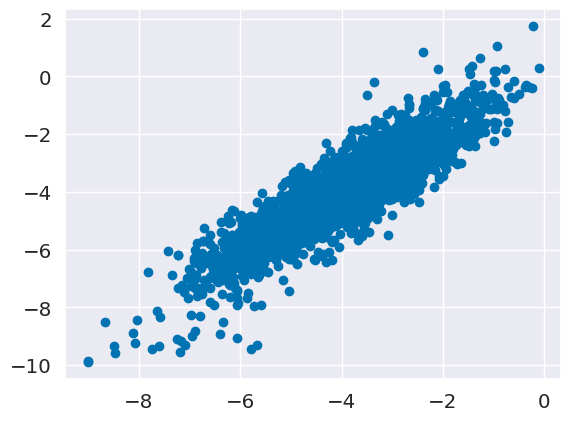

In [244]:
plt.scatter(y_pred_mean, y_test.flatten())

plt.show()